# Apendixes A

In [1]:
# Import core analytical libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import prophet
import itertools
from sklearn.metrics import mean_absolute_percentage_error
%matplotlib inline

In [2]:
# Checking: is the Google Colab available
try:
  import google.colab
  IN_COLAB = True
except ImportError:
  IN_COLAB = False
if IN_COLAB:
  print("Installing additional libraries")
  !pip install ta-lib-bin
  !pip install mplfinance
  !pip install pmdarima
  !pip install arch

In [3]:
# Import specific libraries for Finance
import yfinance as yf
import talib
import mplfinance as mpf
from pmdarima import auto_arima
import arch

## Fetching data from Yahoo Finance

In [5]:
# List of the selected NASDAQ tickers
nasdaq_tickers = [
    'MRNA', 'DLTR', 'ZS', 'MCHP', 'SBUX', 'HON', 'JD', 'DDOG',
    'AMAT', 'AAPL', 'AMGN', 'INTU', 'PCAR', 'MDLZ', 'CSGP',
    'FTNT', 'KDP', 'META', 'VRSK', 'MAR', 'MRVL', 'AZN',
    'ILMN', 'ENPH', 'SIRI', 'MELI', 'ZM', 'TSLA', 'BKR', 'URBN'
]

In [6]:
# Fetching a DataFrame with a Single-Column Index
def fetch_yfinance_single_stock_data(ticker, start=None, end=None, actions=True):
    """
    Fetches historical stock prices for a given ticker and calculates RoR and LogRoR.

    Parameters:
    - ticker: A single ticker symbol as a string or a list of ticker symbols.
    - start: Start date for fetching data. If None, fetches as much data as possible.
    - end: End date for fetching data. If None, defaults to the current date.
    - actions: Boolean flag to control the execution an aditional data fetching.

    Returns:
    - DataFrame with stock prices and additional columns for RoR and LogRoR if actions is True.
    """

    # Fetch historical data
    data = yf.download(ticker, start=start, end=end, actions=actions)

    # Ensure data is a DataFrame (yf.download returns a DataFrame for multiple tickers or a Series for a single ticker)
    if isinstance(data, pd.Series):
        data = data.to_frame(name='Adj Close')

    # Calculating daily percentage change (RoR) and Logarithmic Rate of Return (LogRoR)
    data['RoR'] = data['Adj Close'].pct_change()
    data['LogRoR'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

    return data

# Initialize an empty DataFrame to store the concatenated data
nasdaq_assets_df = pd.DataFrame()

# Iterate over each ticker and fetch its data
for ticker in nasdaq_tickers:
    ticker_data = fetch_yfinance_single_stock_data(ticker, actions=True)

    # If data was fetched successfully, append it to the collective DataFrame
    if ticker_data is not None:
        # Adding a 'Ticker' column to identify the stock in the collective DataFrame
        ticker_data['Ticker'] = ticker

        # Appending the data
        nasdaq_assets_df = pd.concat([nasdaq_assets_df, ticker_data])

# Now, nasdaq_assets_df contains the historical stock prices, RoR, and LogRoR for all specified NASDAQ tickers
print(nasdaq_assets_df.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

                 Open       High    Low      Close  Adj Close    Volume  \
Date                                                                      
2018-12-07  22.000000  22.750000  18.51  18.600000  18.600000  12995600   
2018-12-10  18.900000  19.438999  18.00  18.799999  18.799999   4233300   
2018-12-11  20.549999  20.660000  17.99  18.010000  18.010000   3435300   
2018-12-12  18.549999  19.480000  18.02  18.680000  18.680000   2590700   
2018-12-13  19.250000  19.290001  18.68  18.760000  18.760000   1608600   

            Dividends  Stock Splits       RoR    LogRoR Ticker  
Date                                                            
2018-12-07        0.0           0.0       NaN       NaN   MRNA  
2018-12-10        0.0           0.0  0.010753  0.010695   MRNA  
2018-12-11        0.0           0.0 -0.042021 -0.042930   MRNA  
2018-12-12        0.0           0.0  0.037202  0.036526   MRNA  
2018-12-13        0.0           0.0  0.004283  0.004274   MRNA  


In [8]:
# Fetching a DataFrame with a Multi-Column Index
def fetch_yfinance_stocks_data(tickers,
                               start=None,
                               end=None,
                               actions=True):
    """
    Fetches historical stock data, calculates percentage changes and logRoR,
    and creates a MultiIndex DataFrame.

    Parameters:
    - tickers: List of ticker symbols.
    - start: Start date for fetching data.
    - end: End date for fetching data.
    - actions: Boolean flag to control the execution an aditional data fetching.

    Returns:
    - A MultiIndex DataFrame with 'Adj Close', 'Volume', 'PctChange', and 'logRoR'.
    """

    # Download stock data
    df = yf.download(tickers=tickers, start=start, end=end, actions=actions)

    # Calculate percentage change and logRoR for 'Adj Close'
    pct_change = df['Adj Close'].pct_change()
    logRoR = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

    # Preparing the MultiIndex for new columns
    pct_change.columns = pd.MultiIndex.from_product([['RoR'], pct_change.columns])
    logRoR.columns = pd.MultiIndex.from_product([['logRoR'], logRoR.columns])

    # Concatenating the new 'PctChange' and 'logRoR' DataFrames with the original DataFrame
    df = pd.concat([df, pct_change, logRoR], axis=1)
    df.sort_index(inplace=True)

    return df

# Fetching and processing stock data
nasdaq_assets_df = fetch_yfinance_stocks_data(nasdaq_tickers)
print(nasdaq_assets_df.dropna().head())

[*********************100%%**********************]  30 of 30 completed

            Adj Close                                                          \
Ticker           AAPL       AMAT        AMGN        AZN        BKR       CSGP   
Date                                                                            
2019-09-20  52.732246  48.673512  170.461456  40.275707  20.398840  59.500000   
2019-09-23  52.972015  49.437611  171.171188  39.731926  20.666906  59.500000   
2019-09-24  52.720131  48.864540  170.123871  40.266796  20.450726  58.676998   
2019-09-25  53.531475  49.599976  169.699753  40.418346  21.004148  59.506001   
2019-09-26  53.255383  49.810112  169.111206  40.534233  20.692850  59.458000   

                                                      ...    logRoR            \
Ticker           DDOG        DLTR       ENPH    FTNT  ...      MRNA      MRVL   
Date                                                  ...                       
2019-09-20  36.150002  111.070000  27.469999  15.646  ...  0.009452 -0.030528   
2019-09-23  36.110001  113.

In [11]:
# Fetching Options Data for the selected ticker
# Initialize a Ticker object
apple = yf.Ticker(nasdaq_tickers[0])
# Fetch options data (calls and puts) for the first available expiration date
options_expiration_dates = apple.options  # Get all available options expiration dates
first_expiration_date = options_expiration_dates[0]  # Select the first available expiration date
options_data = apple.option_chain(first_expiration_date)  # Fetch options data for this date
# Display the calls and puts data
print("Calls for first expiration date:")
print(options_data.calls.head())  # Display first few rows of call options data
print("\nPuts for first expiration date:")
print(options_data.puts.head())  # Display first few rows of put options data

Calls for first expiration date:
        contractSymbol             lastTradeDate  strike  lastPrice   bid  \
0  MRNA240607C00070000 2024-05-31 18:40:47+00:00    70.0      71.64  68.0   
1  MRNA240607C00075000 2024-05-31 18:40:16+00:00    75.0      66.64  63.0   
2  MRNA240607C00085000 2024-05-24 18:19:39+00:00    85.0      83.57  53.0   
3  MRNA240607C00090000 2024-05-10 16:02:24+00:00    90.0      29.26  48.1   
4  MRNA240607C00092000 2024-05-31 18:45:07+00:00    92.0      50.05  46.0   

     ask     change  percentChange  volume  openInterest  impliedVolatility  \
0  76.65 -10.349998     -12.623489     1.0             1           4.965824   
1  72.00  66.640000            NaN     1.0             0           4.696781   
2  61.75   0.000000       0.000000     3.0             2           3.890625   
3  57.00   0.000000       0.000000     2.0             2           3.634767   
4  54.70  50.050000            NaN     1.0             0           3.420412   

   inTheMoney contractSize cu

In [10]:
# Fetching risk-free data
# Initialize a Ticker object for the 13-week USA Treasury bill rate
irx = yf.Ticker("^IRX")
# Fetch historical data for the 13-week Treasury bill rate
irx_history = irx.history(period="1y")  # Example: Fetch data for the last year
# Calculate the daily mean of the yearly percentage rate
daily_mean_zero_rate = irx_history['Close'].mean()
print("Mean Yearly Percentage Zero-Rate (13-week Treasury bill) over the last year:")
print(f"{daily_mean_zero_rate:.2f}")
print("Mean Daily Percentage Zero-Rate (13-week Treasury bill) over the last year:")
print(f"{daily_mean_zero_rate / 252:.5f}")

Mean Yearly Percentage Zero-Rate (13-week Treasury bill) over the last year:
5.24
Mean Daily Percentage Zero-Rate (13-week Treasury bill) over the last year:
0.02080


In [13]:
# Fundamental analysis function for stock data from Yahoo Finance
def calculate_fundamentals(ticker_symbol):
    # Fetching financial data for the selected ticker
    ticker = yf.Ticker(ticker_symbol)
    financials = ticker.financials
    balance_sheet = ticker.balance_sheet
    # Retrieving basic earnings per share (EPS) from the financials
    eps = financials.loc['Basic EPS']
    # Calculating the Return on Equity (ROE) by dividing Net Income by Stockholder's Equity
    roe = financials.loc['Net Income'] / balance_sheet.loc['Stockholders Equity']
    # Fetching historical price data for the ticker in the date range of the financial data
    history = ticker.history(start=eps.index[-1].strftime('%Y-%m-%d'),
                             end=eps.index[0].strftime('%Y-%m-%d'),
                             interval='1d')
    # Removing time zone information for ease of comparison
    eps.index = eps.index.tz_localize(None)
    roe.index = roe.index.tz_localize(None)
    history.index = history.index.tz_localize(None)
    # Creating a date range that includes weekends
    full_date_range = pd.date_range(start=eps.index.min(),
                                    end=eps.index.max(),
                                    freq='D')
    # Reindexing the dataframe to include the full date range with weekends
    history_full = history.reindex(full_date_range, method='ffill')
    # Fetching the closing prices from history that match the dates in eps
    close_prices_on_eps_dates = history_full.loc[history_full.index.isin(eps.index), 'Close']
    # Calculating the Price to Earnings (P/E) ratio by dividing the closing price by EPS
    pe_ratio_on_eps_dates = close_prices_on_eps_dates / eps
    return {
        'ticker': ticker_symbol,
        'eps': eps,
        'roe': roe,
        'pe_ratio': pe_ratio_on_eps_dates
    }
# Apply the function for Stock1
aapl_financial_ratios = calculate_fundamentals(nasdaq_tickers[0])
# Print the results for Stock 1
print(f"{aapl_financial_ratios['ticker']} Basic EPS:")
print(aapl_financial_ratios['eps'])
print(f"\n{aapl_financial_ratios['ticker']} Return on Equity (ROE):")
print(aapl_financial_ratios['roe'])
print(f"\n{aapl_financial_ratios['ticker']} P/E Ratio on EPS Dates:")
print(aapl_financial_ratios['pe_ratio'])

MRNA Basic EPS:
2023-12-31   -12.33
2022-12-31    21.26
2021-12-31    30.31
2020-12-31    -1.96
2019-12-31      NaN
Name: Basic EPS, dtype: object

MRNA Return on Equity (ROE):
2023-12-31   -0.340263
2022-12-31    0.437274
2021-12-31    0.862637
2020-12-31   -0.291683
2019-12-31         NaN
dtype: object

MRNA P/E Ratio on EPS Dates:
2019-12-31          NaN
2020-12-31   -53.301021
2021-12-31     8.379413
2022-12-31      8.44873
2023-12-31    -8.065693
Freq: YE-DEC, dtype: object


## Technique and Graphical analyses

In [14]:
# TA-lib for technical analysis indicator calculating
#!pip install ta-lib-bin # uncomment to install library
import talib
ticker=nasdaq_tickers[9]
df1 = fetch_yfinance_single_stock_data(ticker).copy()
# Calculate Bollinger Bands
df1['upper_band'], df1['middle_band'], df1['lower_band'] = talib.BBANDS(
    df1['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
# Calculate MACD
df1['macd'], df1['macdsignal'], df1['macdhist'] = talib.MACD(
    df1['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
# Calculate RSI
df1['rsi'] = talib.RSI(df1['Close'], timeperiod=14)
# Display the head of the DataFrame to see the results
print(df1.tail())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-05-24  188.820007  190.580002  188.039993  189.979996  189.979996   
2024-05-28  191.509995  193.000000  189.100006  189.990005  189.990005   
2024-05-29  189.610001  192.250000  189.509995  190.289993  190.289993   
2024-05-30  190.759995  192.179993  190.630005  191.289993  191.289993   
2024-05-31  191.440002  192.570007  189.910004  192.250000  192.250000   

              Volume  Dividends  Stock Splits       RoR    LogRoR  upper_band  \
Date                                                                            
2024-05-24  36294600        0.0           0.0  0.016588  0.016452  197.869222   
2024-05-28  52280100        0.0           0.0  0.000053  0.000053  198.069459   
2024-05-29  53068000        0.0           0.0  0.001579  0.001578  197.499245   
2024-05-30  49947900        0.0           0.0  0.005255  0.005241  196.09069

[*********************100%%**********************]  1 of 1 completed


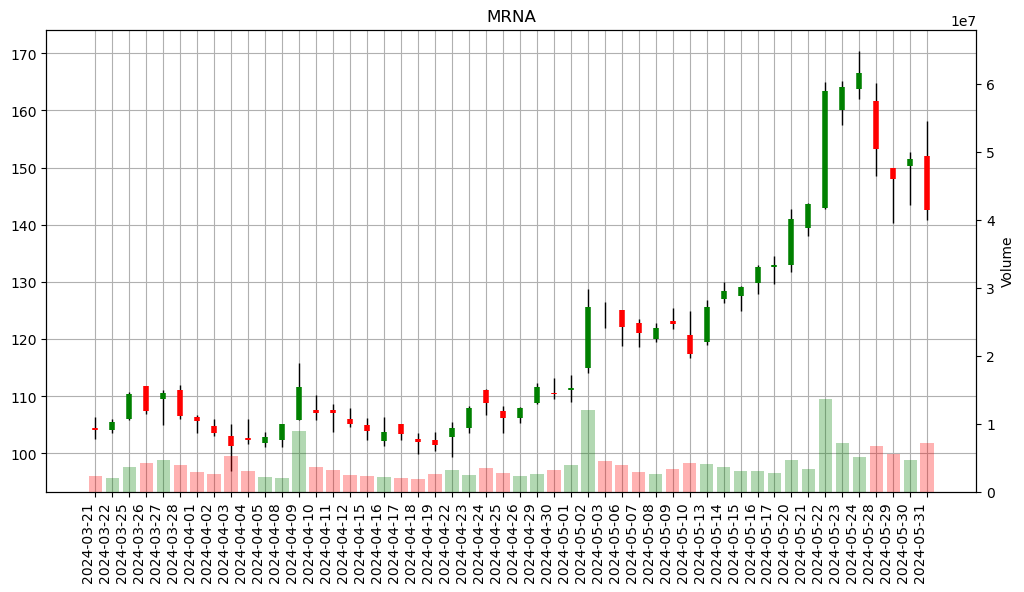

In [15]:
# Candlestick chart within the core libraries
def ohlc_plot_candles_volumes(df, window, figsize=(12, 6), title='Candlestick Chart with Volumes'):
    sample = df.iloc[-window:]
    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()  # Create a second y-axis to plot the volume
    # Define the maximum volume to scale the y-axis of volume bars
    max_vol = sample['Volume'].max()
    for i in range(len(sample)):
        # Plotting the high and low using black line
        ax1.vlines(x=i, ymin=sample.iloc[i]['Low'], ymax=sample.iloc[i]['High'], color='black', linewidth=1)
        # Determine the colour and position of the candle's body
        if sample.iloc[i]['Close'] > sample.iloc[i]['Open']:
            ax1.vlines(x=i, ymin=sample.iloc[i]['Open'], ymax=sample.iloc[i]['Close'], color='green', linewidth=4)
        elif sample.iloc[i]['Close'] < sample.iloc[i]['Open']:
            ax1.vlines(x=i, ymin=sample.iloc[i]['Close'], ymax=sample.iloc[i]['Open'], color='red', linewidth=4)
        else:
            ax1.vlines(x=i, ymin=sample.iloc[i]['Close'], ymax=sample.iloc[i]['Open'] + 0.00003, color='black', linewidth=4)
        # Plotting the volume bars
        color = 'green' if sample.iloc[i]['Close'] > sample.iloc[i]['Open'] else 'red'
        ax2.bar(i, sample.iloc[i]['Volume'], color=color, alpha=0.3)
    # Adjust the y limit of the second axis to fit the volume bars
    ax2.set_ylim(0, max_vol*5)
    ax2.set_ylabel("Volume")
    # Setting x-axis labels to the dates from the DataFrame's index
    ax1.set_xticks(range(len(sample)))
    ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in sample.index], rotation=90, ha='right')
    ax1.grid()
    # Set the title for the plot
    ax1.set_title(title)
    plt.show()
ohlc_plot_candles_volumes(fetch_yfinance_single_stock_data(nasdaq_tickers[0]),
                          50, title=nasdaq_tickers[0])

[*********************100%%**********************]  1 of 1 completed


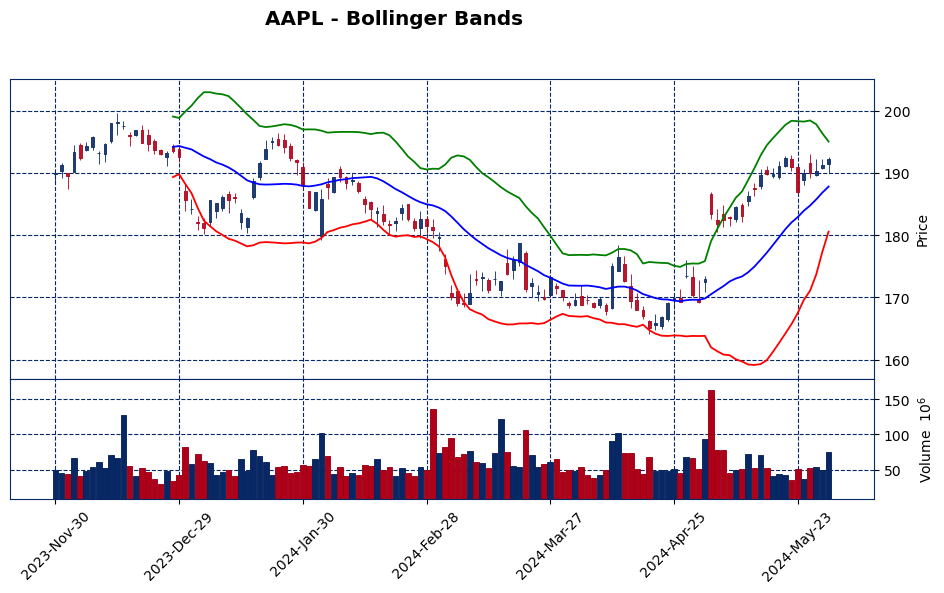

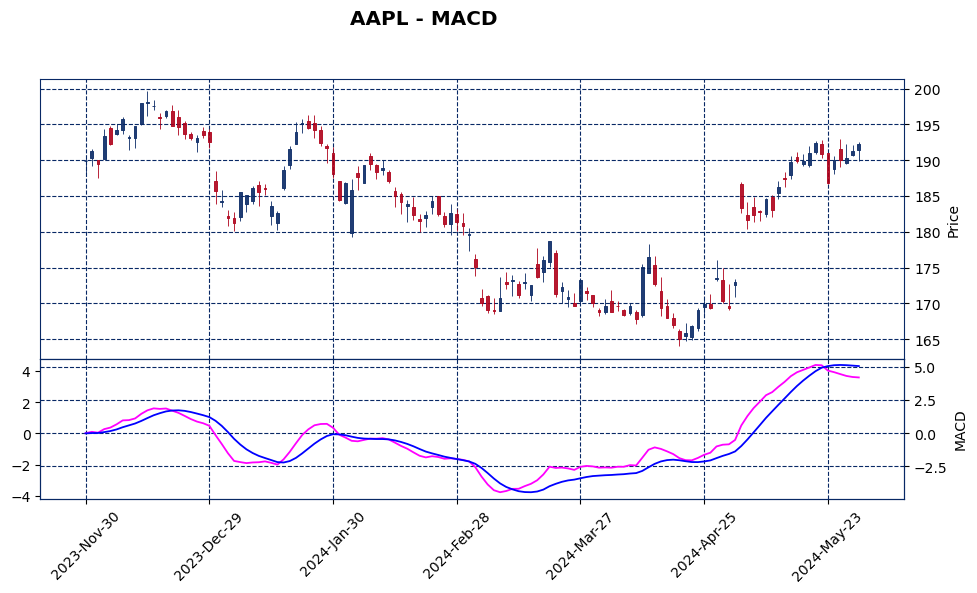

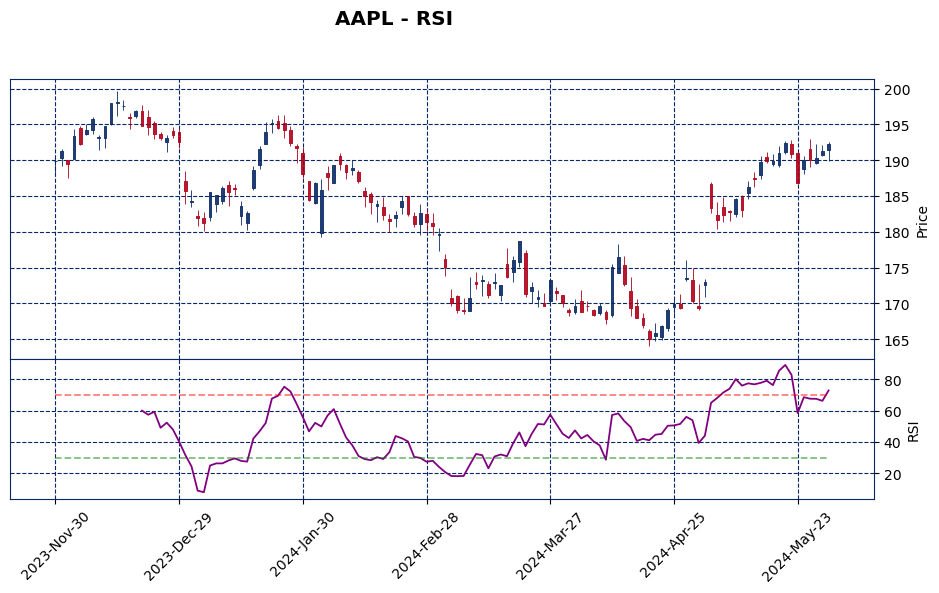

In [16]:
# Import mplfinance for the stock data vizualization
# !pip install mplfinance # uncomment to install library
import mplfinance as mpf
# Bollinger Bands plotting function
def plot_candlestick_with_bb(df, ticker, window=20, no_of_std=2):
    # Calculate Bollinger Bands
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * no_of_std)
    lower_band = rolling_mean - (rolling_std * no_of_std)
    # Plot configuration for Bollinger Bands
    apds = [mpf.make_addplot(upper_band.values, color='green'),
            mpf.make_addplot(rolling_mean.values, color='blue'),  # MVA line
            mpf.make_addplot(lower_band.values, color='red')]
    # Plot with title
    mpf.plot(df, type='candle', addplot=apds, volume=True, title=f"{ticker} - Bollinger Bands",
             figsize=(12, 6), style='starsandstripes')
# MACD plotting function
def plot_candlestick_with_macd(df, ticker, span1=12, span2=26, signal_span=9):
    # Calculate MACD and Signal line
    exp1 = df['Close'].ewm(span=span1, adjust=False).mean()
    exp2 = df['Close'].ewm(span=span2, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_span, adjust=False).mean()
    # Plot configuration for MACD
    apds = [mpf.make_addplot(macd_line.values, panel=1, color='fuchsia', ylabel='MACD'),
            mpf.make_addplot(signal_line.values, panel=1, color='b')]
    # Plot with title
    mpf.plot(df, type='candle', addplot=apds, volume=False, title=f"{ticker} - MACD",
             style='starsandstripes', panel_ratios=(6,3), figsize=(12, 6))
# RSI plotting function
def plot_candlestick_with_rsi(df, ticker, window=14):
    # Calculate RSI
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    roll_up = up.rolling(window=window).mean()
    roll_down = down.rolling(window=window).mean()
    RS = roll_up / roll_down
    rsi_line = 100 - (100 / (1 + RS))
    # Plot configuration for RSI
    apds = [mpf.make_addplot(rsi_line.values, panel=1, color='purple', ylabel='RSI'),
            mpf.make_addplot([70] * len(df), panel=1, color='red', alpha=0.5, linestyle='dashed'),
            mpf.make_addplot([30] * len(df), panel=1, color='green', alpha=0.5, linestyle='dashed')]
    # Plot with title
    mpf.plot(df, type='candle', addplot=apds, volume=False, title=f"{ticker} - RSI",
             style='starsandstripes', panel_ratios=(6,3), figsize=(12, 6))
# Example usage with a single ticker from the NASDAQ list
ticker=nasdaq_tickers[9]
df = fetch_yfinance_single_stock_data(ticker).iloc[-126:].copy()
plot_candlestick_with_bb(df, ticker=ticker)
plot_candlestick_with_macd(df, ticker=ticker)
plot_candlestick_with_rsi(df, ticker=ticker)

## Portfolio optimization

In [17]:
from scipy.optimize import minimize
def portfolio_performance(weights, log_returns, risk_free_rate=0.0):
    """
    Calculate expected portfolio performance metrics: return, volatility, Sharpe ratio.
    Note: risk_free_rate is the annual rate, log returns are daily rates
    """
    expected_return = np.sum(log_returns.mean() * weights) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    sharpe_ratio = (expected_return - risk_free_rate) / volatility
    return expected_return, volatility, sharpe_ratio
def minimize_negative_sharpe(weights, log_returns, risk_free_rate=0.0):
    """
    Objective function to minimize (negative Sharpe ratio).
    """
    return -portfolio_performance(weights, log_returns, risk_free_rate)[2]
def minimize_volatility(weights, log_returns, risk_free_rate=0.0):
    """
    Objective function to minimize portfolio volatility.
    """
    return portfolio_performance(weights, log_returns)[1]
def minimize_negative_return(weights, log_returns):
    """
    Objective function to minimize (negative return).
    """
    return -portfolio_performance(weights, log_returns)[0]
def optimize_portfolio(log_returns, objective_function, risk_free_rate=0.0,
                       min_ror=None, max_vol=None):
    """
    General optimization method.
    """
    num_assets = len(log_returns.columns)
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = np.array([1. / num_assets] * num_assets)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    if min_ror is not None:
        constraints.append({'type': 'ineq', 'fun': lambda x:
                            portfolio_performance(x, log_returns)[0] - min_ror})
    if max_vol is not None:
        constraints.append({'type': 'ineq', 'fun': lambda x:
                            max_vol - portfolio_performance(x, log_returns)[1]})
    # Adjust the args passed to the minimize function based on the objective_function
    if objective_function == minimize_negative_sharpe:
        args = (log_returns, risk_free_rate)
    else:
        args = (log_returns,)
    opt_results = minimize(objective_function, initial_guess, args=args,
                           method='SLSQP', bounds=bounds, constraints=constraints)
    # Print portfolio results
    formatted_weights = [f"{weight:.2f}" for weight in opt_results.x]
    ret = portfolio_performance(opt_results.x, log_returns)[0]
    vol = portfolio_performance(opt_results.x, log_returns)[1]
    print("Optimal Weights: ", formatted_weights)
    print(f"Expected Annual Return: {ret:.2f}")
    print(f"Expected Volatility: {vol:.2f}")
    print()
    return opt_results.x
# Usage example for 2 years daily Returns
start_date = '2022-01-01'
end_date = '2023-12-31'
# Fetch historical data
df = fetch_yfinance_stocks_data(nasdaq_tickers,
                                start=start_date,
                                end=end_date)['Adj Close']
# Annualy risk-free rate
risk_free_rate = (yf.Ticker("^IRX").history(period="2y")['Close'].mean() / 100)
log_returns = np.log(df / df.shift(1)).dropna()
# Optimize results
print("Mathematical Optimization Results")
print("Optimize for maximum Sharpe Ratio:")
sharpe = optimize_portfolio(log_returns,
                            minimize_negative_sharpe,
                            risk_free_rate)
print("Optimize for maximum Returns:")
ror = optimize_portfolio(log_returns,
                         minimize_negative_return)
print("Optimize for minimum Volatility:")
vol = optimize_portfolio(log_returns,
                         minimize_volatility)
max_vol_constraint = 0.15  # Example maximum volatility
print(f"Optimize for maximum Returns with maximum Volatility is {max_vol_constraint}")
optimal_max_ror = optimize_portfolio(log_returns,
                                     minimize_negative_return,
                                     max_vol=max_vol_constraint)
min_ror_constraint = 0.25  # Example minimum rate of return
print(f"Optimize for minimum Volatility with minimum Returns is {min_ror_constraint}")
optimal_min_vol = optimize_portfolio(log_returns,
                                     minimize_volatility,
                                     min_ror=min_ror_constraint)

[*********************100%%**********************]  30 of 30 completed


Mathematical Optimization Results
Optimize for maximum Sharpe Ratio:
Optimal Weights:  ['0.00', '0.00', '0.22', '0.00', '0.05', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.73', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Expected Annual Return: 0.26
Expected Volatility: 0.21

Optimize for maximum Returns:
Optimal Weights:  ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Expected Annual Return: 0.30
Expected Volatility: 0.25

Optimize for minimum Volatility:
Optimal Weights:  ['0.00', '0.00', '0.22', '0.12', '0.07', '0.00', '0.00', '0.01', '0.00', '0.00', '0.07', '0.00', '0.00', '0.01', '0.23', '0.00', '0.00', '0.17', '0.00', '0.00', '0.00', '0.00', '0.04', '0.00', '0.00', '0.00', '0.00', '0.

In [18]:
# Object-oriented implementation
import numpy as np
import pandas as pd
from scipy.optimize import minimize

class PortfolioOptimizer:
    def __init__(self, log_returns, risk_free_rate=0.0):
        """
        Initialize the PortfolioOptimizer with log returns and a risk-free rate.
        """
        self.log_returns = log_returns
        self.risk_free_rate = risk_free_rate
        self.num_assets = log_returns.shape[1]
        self.optimal_weights = None

    def portfolio_performance(self, weights):
        """
        Calculate expected portfolio performance metrics: return, volatility, Sharpe ratio.
        """
        expected_return = np.sum(self.log_returns.mean() * weights) * 252
        volatility = np.sqrt(np.dot(weights.T, np.dot(self.log_returns.cov() * 252, weights)))
        sharpe_ratio = (expected_return - self.risk_free_rate) / volatility
        return expected_return, volatility, sharpe_ratio

    def _objective(self, weights, objective_type):
        """
        Internal method to define the objective function based on the type.
        """
        if objective_type == 'sharpe':
            return -self.portfolio_performance(weights)[2]
        elif objective_type == 'return':
            return -self.portfolio_performance(weights)[0]
        elif objective_type == 'volatility':
            return self.portfolio_performance(weights)[1]

    def fit(self, objective_type='sharpe', min_ror=None, max_vol=None):
        """
        Find optimal weights based on the specified objective: 'sharpe', 'return', or 'volatility'.
        """
        bounds = tuple((0, 1) for _ in range(self.num_assets))
        initial_guess = np.array([1. / self.num_assets] * self.num_assets)

        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        if min_ror is not None:
            constraints.append({'type': 'ineq', 'fun': lambda x:
                                self.portfolio_performance(x)[0] - min_ror})
        if max_vol is not None:
            constraints.append({'type': 'ineq', 'fun': lambda x:
                                max_vol - self.portfolio_performance(x)[1]})

        opt_results = minimize(lambda weights: self._objective(weights, objective_type),
                               initial_guess, method='SLSQP', bounds=bounds,
                               constraints=constraints)

        self.optimal_weights = opt_results.x
        return self.optimal_weights

    def results(self):
        """
        Print and return the portfolio performance of the optimized weights.
        """
        if self.optimal_weights is None:
            print("Optimizer has not been fit yet.")
            return None

        ret, vol, sharpe = self.portfolio_performance(self.optimal_weights)
        formatted_weights = [f"{weight:.2f}" for weight in self.optimal_weights]
        print(f"Optimal Weights: {formatted_weights}")
        print(f"Expected Annual Return: {ret:.2%}")
        print(f"Expected Volatility: {vol:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}\n")
        return {'return': ret, 'volatility': vol, 'sharpe_ratio': sharpe}

# Example usage
optimizer = PortfolioOptimizer(log_returns, risk_free_rate)
optimizer.fit(objective_type='sharpe')
print(optimizer.results())
print(optimizer.optimal_weights)

Optimal Weights: ['0.00', '0.00', '0.22', '0.00', '0.05', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.73', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Expected Annual Return: 26.13%
Expected Volatility: 20.53%
Sharpe Ratio: 1.05

{'return': 0.26134668995921884, 'volatility': 0.20532369805710635, 'sharpe_ratio': 1.0544444023942838}
[0.00000000e+00 0.00000000e+00 2.21236720e-01 0.00000000e+00
 4.54348219e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.61119511e-11
 0.00000000e+00 0.00000000e+00 2.70716399e-11 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.33328458e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


## Statsmodels regression

In [19]:
import statsmodels.api as sm

def capm_regression_and_visualization(index_returns,
                                      stock_returns,
                                      risk_free_rate=0.0):
    """
    Performs CAPM regression analysis and visualization, incorporating the risk-free rate.

    Parameters:
    - index_returns: Pandas Series of percentage changes for the market index.
    - stock_returns: Pandas Series of percentage changes for the stock.
    - risk_free_rate: The risk-free rate for calculating excess returns.

    Returns:
    - A dictionary containing the regression results and model parameters.
    """
    # Ensure there are no NaN values
    index_returns = index_returns.dropna()
    stock_returns = stock_returns.dropna()
    # Adjust for risk-free rate to get excess returns
    excess_stock_return = stock_returns - risk_free_rate
    excess_market_return = index_returns - risk_free_rate
    # Add a constant to the independent variable
    X = sm.add_constant(excess_market_return)
    # Perform OLS regression
    model = sm.OLS(excess_stock_return, X)
    results = model.fit()
    # Extract regression parameters
    beta = results.params[1]
    alpha = results.params[0]
    r_value = results.rsquared ** 0.5
    p_value = results.pvalues[1]
    std_err = results.bse[1]
    # Return model results and parameters
    return {
        'beta': beta,
        'alpha': alpha,
        'correlation_coefficient': r_value,
        'p_value': p_value,
        'standard_error': std_err,
        'regression_summary': results.summary()
    }
# Example usage
# Assuming index_data and df are DataFrame containing the market index and stock data respectively
r_m = fetch_yfinance_single_stock_data('^NDX',
                                       start ='2021-01-01',
                                       end='2023-12-31',
                                       actions=False)['LogRoR']
r_s = fetch_yfinance_single_stock_data('AAPL',                  # Apple inc. data
                                       start ='2021-01-01',
                                       end='2023-12-31',
                                       actions=False)['LogRoR']
# risk_free_rate = 0.01  # Example risk-free rate
results = capm_regression_and_visualization(r_m, r_s)
print(results)


# Optimized Portfolio data
# Usage example for 2 years daily Returns
start_date = '2022-01-01'
end_date = '2023-12-31'
# Fetch historical data
df = fetch_yfinance_stocks_data(nasdaq_tickers,
                                start=start_date,
                                end=end_date)['Adj Close']
# Annualy risk-free rate
risk_free_rate = (yf.Ticker("^IRX").history(period="2y")['Close'].mean() / 100) / 252
log_returns = np.log(df / df.shift(1)).dropna()

r_p = log_returns.mul(sharpe, axis=1).sum(axis=1)

results = capm_regression_and_visualization(r_m[r_p.index],
                                            r_p, risk_free_rate)
print(results)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_15204/1903274715.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = results.params[1]
/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_15204/1903274715.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = results.params[0]
/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_15204/1903274715.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future versio

{'beta': 0.9790171366191063, 'alpha': 0.000184767294048923, 'correlation_coefficient': 0.8489196697868032, 'p_value': 6.798491318196143e-210, 'standard_error': 0.02225645799148263, 'regression_summary': <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                 LogRoR   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1935.
Date:                Sun, 02 Jun 2024   Prob (F-statistic):          6.80e-210
Time:                        21:03:48   Log-Likelihood:                 2455.5
No. Observations:                 752   AIC:                            -4907.
Df Residuals:                     750   BIC:                            -4898.
Df Model:                           1                                         
Covariance Type:            nonrobust 

/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_15204/1903274715.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = results.params[1]
/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_15204/1903274715.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = results.params[0]
/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_15204/1903274715.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


## Time Series data featuring

In [21]:
# Define the function of lagged feature creation
def create_lagged_features(df, max_lag=5, prediction_window=1,
                           seasonal = True):
    '''
    Create a DataFrame with lagged features and datetime features.

    Parameters:
    df (pd.DataFrame): Input DataFrame with each column being a time series.
    max_lag (int): Maximum lag to create lagged features.
    prediction_window (int): The number of steps to predict.
    seasonal(bool): If is True, the datetime features are applied.

    Returns:
    pd.DataFrame: DataFrame with the first column as the target and others
                  as lagged features and datetime features.
    '''
    lagged_df = pd.DataFrame(index=df.index)
    for col in df.columns:
      # Create target column for prediction
      if prediction_window > 0:
          lagged_df[f'{col}_target_plus_{prediction_window}d'] = df[col].shift(-prediction_window)
      # Create lagged features for each column
      for l in range(0, max_lag):
          lagged_df[f'{col}_lag_{l}'] = df[col].shift(l)
    # Adding datetime (seasonality) features
    if seasonal:
      lagged_df['day'] = lagged_df.index.day
      lagged_df['dayofweek'] = lagged_df.index.dayofweek
      lagged_df['month'] = lagged_df.index.month
      lagged_df['dayofyear'] = lagged_df.index.dayofyear
    return lagged_df
# Fetching data and features preparation
data = fetch_yfinance_single_stock_data(['AZN']).loc['2022':'2023']
features = create_lagged_features(data[['Volume']],
                                  max_lag=1,
                                  prediction_window=1,
                                  seasonal = True)
dataframe = pd.concat([data, features], axis=1)
dataframe.dropna(inplace=True)
print(dataframe.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2022-01-03  58.270000  58.369999  57.750000  58.310001  54.933758  3321000   
2022-01-04  57.160000  57.700001  57.070000  57.270000  53.953968  4646600   
2022-01-05  57.240002  57.730000  56.849998  56.880001  53.586552  4804400   
2022-01-06  56.810001  57.040001  56.110001  56.669998  53.388710  6196400   
2022-01-07  56.650002  57.549999  56.529999  57.480000  54.151814  4594800   

            Dividends  Stock Splits       RoR    LogRoR  \
Date                                                      
2022-01-03        0.0           0.0  0.001030  0.001030   
2022-01-04        0.0           0.0 -0.017836 -0.017997   
2022-01-05        0.0           0.0 -0.006810 -0.006833   
2022-01-06        0.0           0.0 -0.003692 -0.003699   
2022-01-07        0.0           0.0  0.014293  0.014192   

            Volume_target_plus_1d  Volu

## SARIMAX parameters tunning

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  490
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -700.425
Date:                Sun, 02 Jun 2024   AIC                           1412.849
Time:                        21:08:41   BIC                           1438.004
Sample:                             0   HQIC                          1422.729
                                - 490                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0494      0.151      0.327      0.744      -0.247       0.346
ar.L1         -1.2424      0.009   -143.033      0.000      -1.259      -1.225
ar.L2         -0.9940      0.009   -105.551      0.0

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


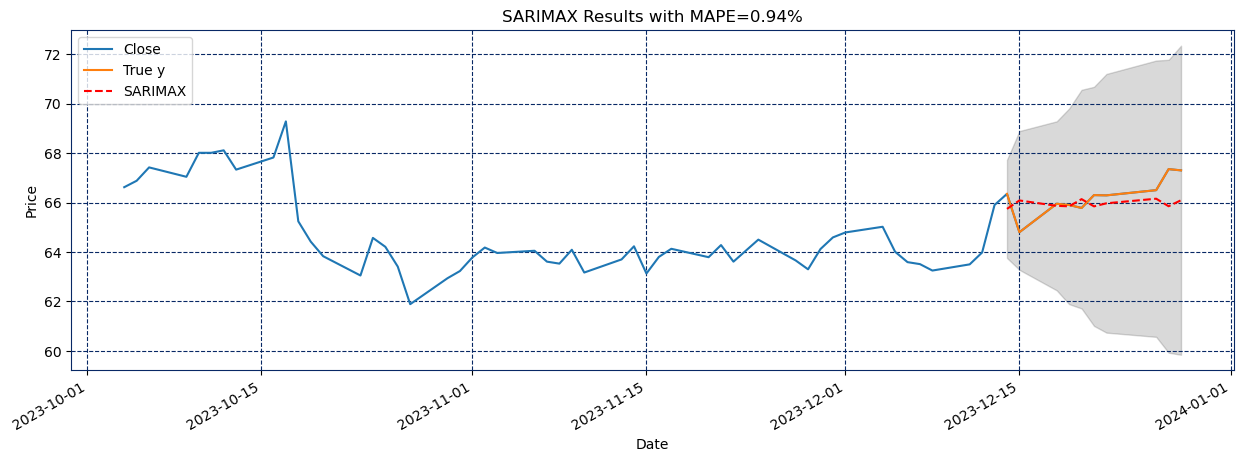

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [22]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error

def tune_forecast_sarimax(dataframe, target_col, exog_cols=None,
                          test_size=21, d=1, m=10, seasonal=True):
    """
    Auto-tune and forecast using SARIMAX model.

    Parameters:
    - dataframe: pd.DataFrame containing the time series and exogenous variables.
    - target_col: str, name of the target variable column.
    - exog_cols: list of str, names of the exogenous variable columns.
    - test_size: int, the number of observations to use for the test set.
    - d: int, order of differencing.
    - m: int, seasonal periodicity.

    Returns:
    - None, displays a plot of the actual vs predicted values with confidence intervals.
    """
    # Split into train and test sets
    train_set = dataframe.iloc[:-test_size]
    test_set = dataframe.iloc[-test_size:]
    # Prepare exogenous variables if provided
    X_train = train_set[exog_cols] if exog_cols else None
    X_test = test_set[exog_cols] if exog_cols else None
    # SARIMAX model tuning
    model = auto_arima(y=train_set[target_col],
                       X=X_train, d=d, m=m,
                       n_jobs=-1,
                       seasonal=seasonal,
                       stepwise=False)
    print(model.summary())
    # Generate predictions and confidence intervals
    forecast, conf_int = model.predict(n_periods=test_size, X=X_test, return_conf_int=True)
    # Convert forecast and confidence intervals to pandas Series for easier plotting
    predictions = pd.Series(forecast).rename("SARIMAX")
    predictions.index = test_set.index
    lower_conf = pd.Series(conf_int[:, 0], index=test_set.index).rename("Lower CI")
    upper_conf = pd.Series(conf_int[:, 1], index=test_set.index).rename("Upper CI")
    # Calculate MAPE
    m_mape = mean_absolute_percentage_error(test_set[target_col], predictions) * 100
    # Plotting the results
    plt.figure(figsize=(15, 5))
    dataframe[-60:][target_col].plot(legend=True,
                                     title=f'SARIMAX Results with MAPE={m_mape:.2f}%')
    plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='k', alpha=0.15)
    test_set[target_col].rename('True y').plot(legend=True)
    predictions.plot(legend=True, color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.show()
    return model
# Example usage
tune_forecast_sarimax(dataframe=dataframe,
                      target_col='Close',
                      # exog_cols=['month', 'Volume_lag_1'],
                      test_size=10,
                      d=1,
                      m=12)

## VAR

Historical Method.
With 95% confidence, the values will not exceed a loss of 3.05%.
With 95% confidence, the values will not exceed a loss of 4.16%.


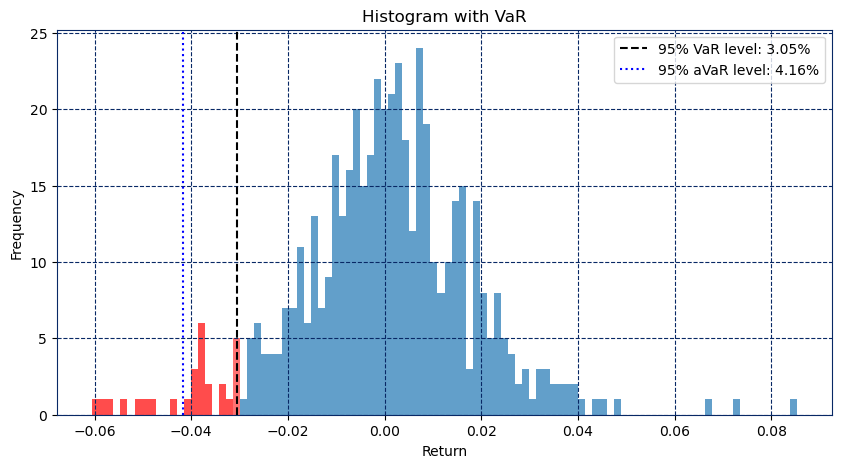

{-0.0416389569745442, -0.03052165786592555}

In [23]:
# Calculate and plot VAR and aVAR
def calculating_VaRs_hist(data, confidence_level = 0.95,
                          out_text = False, out_viz = False):
    # Sort the log returns
    data_sorted = data.sort_values()
    # Calculate the VaR
    historical_var = data_sorted.quantile(1 - confidence_level)
    # Calculate the aVaR
    avar = data_sorted[data_sorted <= historical_var].mean()
    # Print the Value at Risk (VaR) result
    if out_text:
      print('Historical Method.')
      print(f'With 95% confidence, the values will not exceed a loss of {-historical_var * 100:.2f}%.')
      print(f'With 95% confidence, the values will not exceed a loss of {-avar * 100:.2f}%.')
    if out_viz:
      # Plot the histogram with 100 bins
      plt.figure(figsize=(10, 5))
      n, bins, patches = plt.hist(data_sorted, bins=100, alpha=0.7)
      for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
          if rightside <= historical_var:
              patch.set_facecolor('red')
          if leftside < historical_var <= rightside:
              fraction = (historical_var - leftside) / (rightside - leftside)
              patch.set_facecolor('red')
              patch.set_alpha(fraction)
      plt.axvline(historical_var, color='k', linestyle='--',
                  label=f'95% VaR level: {-historical_var * 100:.2f}%')
      plt.axvline(avar, color='b', linestyle=':',
                  label=f'95% aVaR level: {-avar * 100:.2f}%')
      plt.title('Histogram with VaR')
      plt.xlabel('Return')
      plt.ylabel('Frequency')
      plt.legend()
      plt.show()
    # Return VaR and aVaR
    return({historical_var, avar})

calculating_VaRs_hist(log_returns['AAPL'], out_viz=True, out_text=True)

## GARCH models

In [23]:
#!pip install arch # uncomment to install library
from arch import arch_model
import itertools

def auto_tune_garch(data, param_dict, dist='normal',
                    information_criterion='aic',
                    pvalues = 0.05):
    """
    Automatically tune GARCH model parameters.

    Parameters:
    - data: pd.Series, the time series data.
    - param_dict: dict, dictionary where keys are parameter names ('p', 'q', etc.)
      and values are lists of parameter values to iterate over.
    - dist: str, the distribution assumption ('normal', 't', etc.).
    - information_criterion: str, criterion to select the best model ('aic' or 'bic').

    Returns:
    - Best model fit based on the specified information criterion.
    """
    best_ic = np.inf
    best_model = None
    best_params = {}
    # Create a list of all parameter combinations to iterate over
    param_names = sorted(param_dict)
    param_combinations = itertools.product(*(param_dict[name] for name in param_names))
    for params in param_combinations:
        try:
            # Unpack parameters for the current combination
            model_params = dict(zip(param_names, params))
            # Specify and fit the model
            model = arch_model(data, dist=dist, **model_params)
            model_fit = model.fit(disp='off')
            # Select the best model based on the specified information criterion
            if information_criterion == 'aic':
                current_ic = model_fit.aic
            else:
                current_ic = model_fit.bic

            if (current_ic < best_ic):
              if np.sum(model_fit.pvalues > pvalues) == 0:
                  best_ic = current_ic
                  best_model = model_fit
                  best_params = model_params
        except Exception as e:
            print(f"Error with parameters {params}: {e}")
            continue
    print(f"Best Model: {best_params} with {information_criterion.upper()}={best_ic}")
    if best_model is not None:
        print(best_model.summary())
    return best_model
# Example usage:
param_dict = {
    'p': range(1, 5),  # Example range for p
    'q': range(1, 5),   # Example range for q
    'mean': ['Zero', 'Constant', 'AR']
}
best_model = auto_tune_garch(log_returns['AAPL'],
                             param_dict, dist='normal',
                             information_criterion='aic',
                             pvalues=0.1)

/Users/dzher/miniconda3/envs/PythonFinance/lib/python3.8/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000334. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/dzher/miniconda3/envs/PythonFinance/lib/python3.8/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000334. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/dzher/miniconda

Best Model: {'mean': 'Zero', 'p': 1, 'q': 1} with AIC=-2640.2041116537703
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:                1323.10
Distribution:                  Normal   AIC:                          -2640.20
Method:            Maximum Likelihood   BIC:                          -2627.56
                                        No. Observations:                  500
Date:                Mon, Feb 12 2024   Df Residuals:                      500
Time:                        06:47:44   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------

/Users/dzher/miniconda3/envs/PythonFinance/lib/python3.8/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000334. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/dzher/miniconda3/envs/PythonFinance/lib/python3.8/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000334. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/dzher/miniconda

## Prophet library: model parameters define, hyperparameters tune with cross-validation

In [24]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from sklearn.metrics import mean_absolute_percentage_error

def tune_prophet_model(df_train, df_test, param_grid, regressors=None,
                       cv_initial='504 days', cv_period='126 days', cv_horizon='5 days'):
    """
    Tune Prophet model parameters including optional regressors.

    Parameters:
    - df_train: DataFrame with columns ds, y, and optionally additional regressors for training.
    - df_test: DataFrame with columns ds, y, and optionally additional regressors for testing.
    - param_grid: Dictionary with parameter names as keys and lists of parameter settings to try as values.
    - regressors: List of strings, names of additional regressor columns in df_train and df_test.
    - cv_initial: String, initial period size for cross-validation.
    - cv_period: String, period size for cross-validation.
    - cv_horizon: String, horizon size for cross-validation.

    Returns:
    - best_params: Best parameters based on cross-validation MAPE.
    - model: Fitted Prophet model with best parameters.
    """
    if regressors is None:
        regressors = []
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []  # Store the MAPEs for each parameter set here
    for params in all_params:
        m = Prophet(**params)
        # Add regressors if specified
        for regressor in regressors:
            m.add_regressor(regressor)
        m.fit(df_train)  # Fit model with given params
        df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon=cv_horizon)
        df_p = performance_metrics(df_cv, rolling_window=1)
        mapes.append(df_p['mape'].values[0])  # Collect MAPE
    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mape'] = mapes
    best_params = all_params[np.argmin(mapes)]
    print("Tuning results:\n", tuning_results)
    print("\nBest parameters:\n", best_params)
    # Fit the best model
    m_best = Prophet(**best_params)
    for regressor in regressors:
        m_best.add_regressor(regressor)
    m_best.fit(df_train)
    # Model evaluation
    forecast = m_best.predict(df_test)
    mape = mean_absolute_percentage_error(df_test['y'], forecast['yhat']) * 100
    print(f"\nTuned model for test data: MAPE = {mape:.2f}%")
    return best_params, m_best
# Example usage:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.5, 0.9],
    'seasonality_prior_scale': [0.01, 8.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}
# Defining df_train and df_test for Prophet
data = fetch_yfinance_single_stock_data('AZN',
                                        start='2021-01-01',
                                        end='2023-12-31', actions=False)
df = pd.DataFrame({
    'ds': pd.to_datetime(data.index),
    'y': data['Close']
})
test_period = 5
df_train = df[:-test_period]
df_test = df[-test_period:]
best_params, model = tune_prophet_model(df_train, df_test, param_grid)

[*********************100%%**********************]  1 of 1 completed
21:09:48 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:49 - cmdstanpy - INFO - Chain [1] done processing
21:09:49 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:50 - cmdstanpy - INFO - Chain [1] start processing
21:09:50 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:51 - cmdstanpy - INFO - Chain [1] done processing
21:09:51 - cmdstanpy - INFO - Chain [1] start processing
21:09:52 - cmdstanpy - INFO - Chain [1] done processing
21:09:52 - cmdstanpy - INFO - Chain [1] start processing
21:09:52 - cmdstanpy - INFO - Chain [1] done processing
21:09:52 - cmdstanpy - INFO - Chain [1] start processing
21:09:52 - cmdstanpy - INFO - Chain [1] done processing
21:09:52 - cmdstanpy - INFO - Chain [1] start processing
21:09:52 - cmdstanpy - INFO - Chain [1] done processing
21:09:52 - cmdstanpy - INFO - Chain [1] start processing
21:09:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:52 - cmdstanpy - INFO - Chain [1] start processing
21:09:52 - cmdstanpy - INFO - Chain [1] done processing
21:09:52 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing
21:09:53 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing
21:09:53 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing
21:09:53 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing
21:09:53 - cmdstanpy - INFO - Chain [1] start processing
21:09:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:54 - cmdstanpy - INFO - Chain [1] start processing
21:09:54 - cmdstanpy - INFO - Chain [1] done processing
21:09:54 - cmdstanpy - INFO - Chain [1] start processing
21:09:54 - cmdstanpy - INFO - Chain [1] done processing
21:09:54 - cmdstanpy - INFO - Chain [1] start processing
21:09:54 - cmdstanpy - INFO - Chain [1] done processing
21:09:54 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing
21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing
21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing
21:09:56 - cmdstanpy - INFO - Chain [1] start processing
21:09:56 - cmdstanpy - INFO - Chain [1] done processing
21:09:56 - cmdstanpy - INFO - Chain [1] start processing
21:09:56 - cmdstanpy - INFO - Chain [1] done processing
21:09:56 - cmdstanpy - INFO - Chain [1] start processing
21:09:56 - cmdstanpy - INFO - Chain [1] done processing
21:09:56 - cmdstanpy - INFO - Chain [1] start processing
21:09:57 - cmdstanpy - INFO - Chain [1] done processing
21:09:57 - cmdstanpy - INFO - Chain [1] start processing
21:09:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:09:57 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing
21:09:58 - cmdstanpy - INFO - Chain [1] start processing
21:09:58 - cmdstanpy - INFO - Chain [1] done processing
21:09:58 - cmdstanpy - INFO - Chain [1] start processing
21:09:59 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:09:59 - cmdstanpy - INFO - Chain [1] done processing
21:09:59 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing
21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:10:00 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:02 - cmdstanpy - INFO - Chain [1] start processing
21:10:02 - cmdstanpy - INFO - Chain [1] done processing
21:10:02 - cmdstanpy - INFO - Chain [1] start processing
21:10:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:10:02 - cmdstanpy - INFO - Chain [1] start processing
21:10:03 - cmdstanpy - INFO - Chain [1] done processing
21:10:03 - cmdstanpy - INFO - Chain [1] start processing
21:10:03 - cmdstanpy - INFO - Chain [1] done processing
21:10:03 - cmdstanpy - INFO - Chain [1] start processing
21:10:04 - cmdstanpy - INFO - Chain [1] done processing
21:10:04 - cmdstanpy - INFO - Chain [1] start processing
21:10:04 - cmdstanpy - INFO - Chain [1] done processing
21:10:04 - cmdstanpy - INFO - Chain [1] start processing
21:10:05 - cmdstanpy - INFO - Chain [1] done processing
21:10:05 - cmdstanpy - INFO - Chain [1] start processing
21:10:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:10:05 - cmdstanpy - INFO - Chain [1] start processing
21:10:06 - cmdstanpy - INFO - Chain [1] done processing
21:10:06 - cmdstanpy - INFO - Chain [1] start processing
21:10:06 - cmdstanpy - INFO - Chain [1] done processing
21:10:06 - cmdstanpy - INFO - Chain [1] start processing
21:10:06 - cmdstanpy - INFO - Chain [1] done processing
21:10:06 - cmdstanpy - INFO - Chain [1] start processing
21:10:06 - cmdstanpy - INFO - Chain [1] done processing
21:10:06 - cmdstanpy - INFO - Chain [1] start processing
21:10:07 - cmdstanpy - INFO - Chain [1] done processing
21:10:07 - cmdstanpy - INFO - Chain [1] start processing
21:10:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:10:07 - cmdstanpy - INFO - Chain [1] start processing
21:10:07 - cmdstanpy - INFO - Chain [1] done processing
21:10:07 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing
21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:09 - cmdstanpy - INFO - Chain [1] done processing
21:10:09 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:10:11 - cmdstanpy - INFO - Chain [1] start processing
21:10:11 - cmdstanpy - INFO - Chain [1] done processing
21:10:11 - cmdstanpy - INFO - Chain [1] start processing
21:10:12 - cmdstanpy - INFO - Chain [1] done processing
21:10:12 - cmdstanpy - INFO - Chain [1] start processing
21:10:12 - cmdstanpy - INFO - Chain [1] done processing
21:10:12 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing
21:10:13 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing
21:10:13 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:10:13 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:15 - cmdstanpy - INFO - Chain [1] done processing
21:10:15 - cmdstanpy - INFO - Chain [1] start processing
21:10:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

21:10:15 - cmdstanpy - INFO - Chain [1] start processing
21:10:16 - cmdstanpy - INFO - Chain [1] done processing
21:10:16 - cmdstanpy - INFO - Chain [1] start processing
21:10:16 - cmdstanpy - INFO - Chain [1] done processing
21:10:16 - cmdstanpy - INFO - Chain [1] start processing
21:10:17 - cmdstanpy - INFO - Chain [1] done processing
21:10:17 - cmdstanpy - INFO - Chain [1] start processing
21:10:17 - cmdstanpy - INFO - Chain [1] done processing
21:10:17 - cmdstanpy - INFO - Chain [1] start processing
21:10:18 - cmdstanpy - INFO - Chain [1] done processing
21:10:18 - cmdstanpy - INFO - Chain [1] start processing


Tuning results:
     changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                      0.01                     0.01         additive   
1                      0.01                     0.01   multiplicative   
2                      0.01                     8.00         additive   
3                      0.01                     8.00   multiplicative   
4                      0.01                    10.00         additive   
5                      0.01                    10.00   multiplicative   
6                      0.50                     0.01         additive   
7                      0.50                     0.01   multiplicative   
8                      0.50                     8.00         additive   
9                      0.50                     8.00   multiplicative   
10                     0.50                    10.00         additive   
11                     0.50                    10.00   multiplicative   
12                     0.90       

21:10:18 - cmdstanpy - INFO - Chain [1] done processing



Tuned model for test data: MAPE = 2.26%


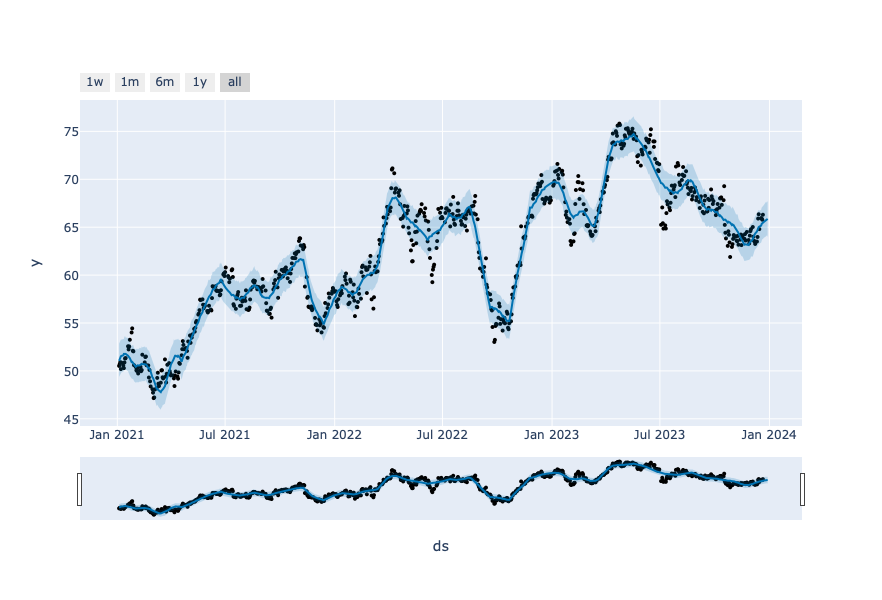

In [26]:
from prophet.plot import plot_plotly
forecast=model.predict(df)
fig = plot_plotly(model, forecast)
fig.show()

# Appendixes
## &copy; Dr. Dmytro Zherlitsyn, 2024  <br>
## &copy; BPB Publications, 2024